In [3]:
import pandas as pd
import numpy as np
data=pd.read_excel('/home/ykkim/Train_data/무림페이퍼_15분사용전력_210401-220630.xlsx')  
data=data.drop(['등록시각'],axis=1)

data['기준시각']=pd.to_datetime(data['기준시각'])
data.info()
len(data)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준시각         42766 non-null  datetime64[ns]
 1   직전 15분 사용전력  42766 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 668.3 KB


42766

In [4]:
#daterange
dates = pd.date_range('2021-04-01 00:00:00', periods=43776, freq='15min')
dates = pd.DataFrame(dates,columns=['기준시각'])

#leftjoin
datas=pd.merge(dates,data,how='left',on='기준시각')

print(datas.isna().sum(), datas['직전 15분 사용전력'].min(),datas['직전 15분 사용전력'].max(),datas['직전 15분 사용전력'].median())

datas
datas.info()


기준시각              0
직전 15분 사용전력    1010
dtype: int64 571.2 8820.0 7341.6
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43776 entries, 0 to 43775
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준시각         43776 non-null  datetime64[ns]
 1   직전 15분 사용전력  42766 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 MB


In [5]:
#이상치 제거
# 5100 이하값들은 이전 값들로 대체
import numpy as np
from scipy import interpolate
datas.loc[(datas['직전 15분 사용전력'] <= 5100),'직전 15분 사용전력']= np.nan
print(datas.isna().sum())
print(datas['직전 15분 사용전력'].min(),datas['직전 15분 사용전력'].max(),datas['직전 15분 사용전력'].median())
print(datas.isna().sum())
# 선형 보간(linear)

datas['직전 15분 사용전력']=datas['직전 15분 사용전력'].interpolate()
print(datas.isna().sum())

# print(data.isna().sum())

기준시각              0
직전 15분 사용전력    2894
dtype: int64
5107.2 8820.0 7425.6
기준시각              0
직전 15분 사용전력    2894
dtype: int64
기준시각           0
직전 15분 사용전력    0
dtype: int64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


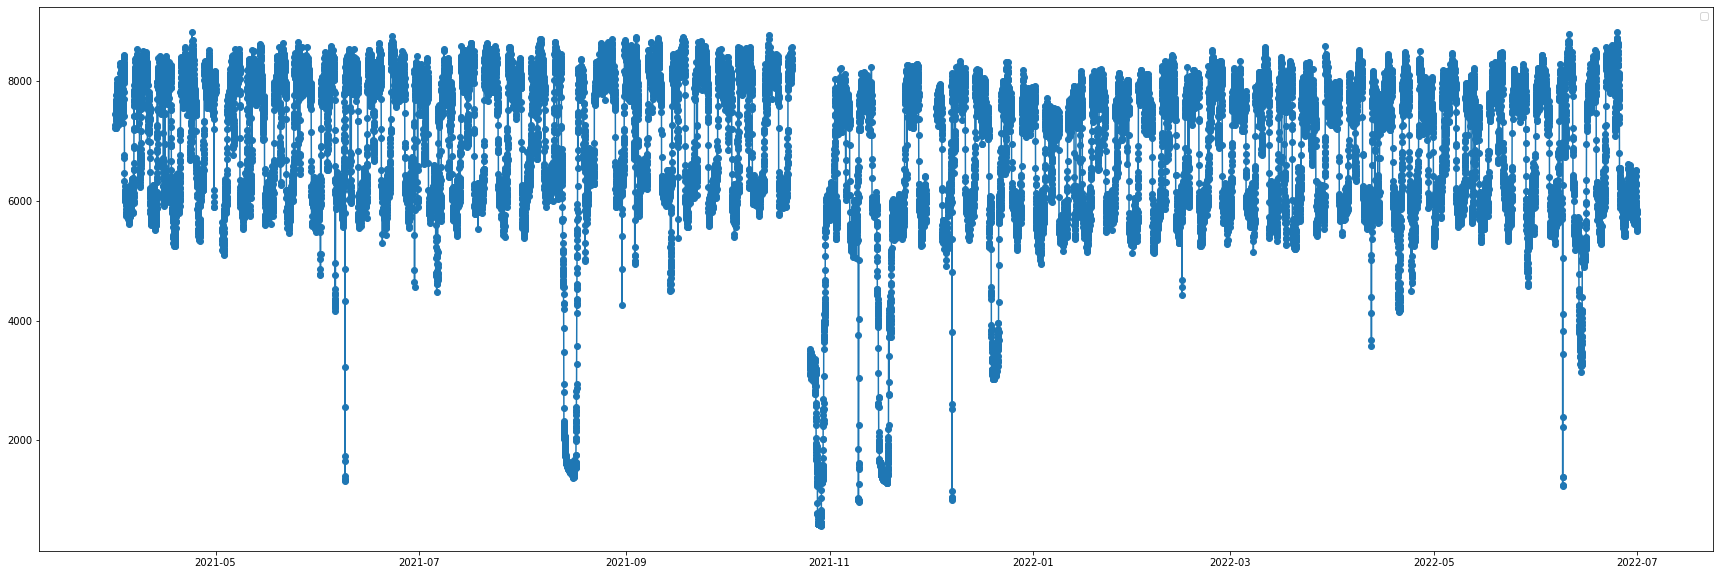

In [3]:
# 기존 데이터 그래프
import matplotlib.pyplot as plt

plt.figure(figsize=(30,10))
kws = dict(marker='o')
plt.plot(datas['기준시각'],datas['직전 15분 사용전력'], **kws)   
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


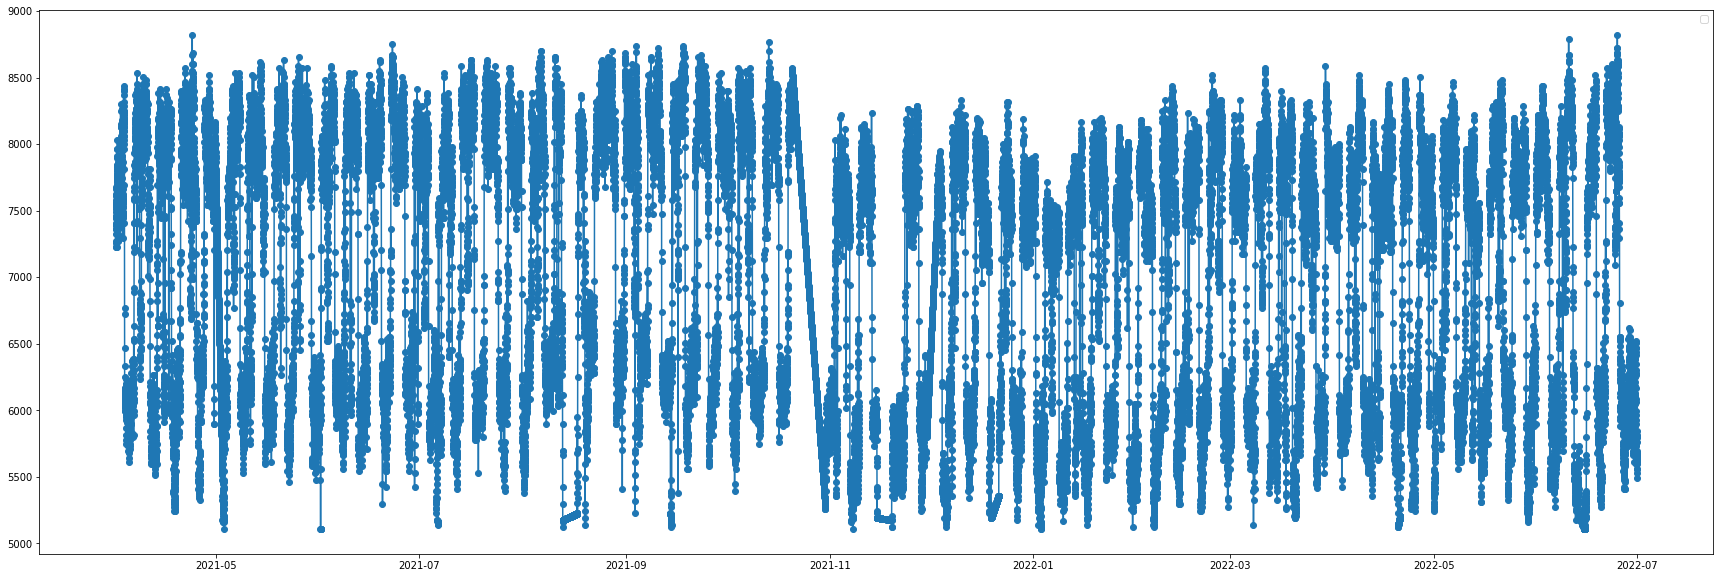

기준시각           0
직전 15분 사용전력    0
dtype: int64


In [6]:
# 기존 데이터 그래프(이상치제거 후 선형 보간법으로 대체)
import matplotlib.pyplot as plt

plt.figure(figsize=(30,10))
kws = dict(marker='o')
plt.plot(datas['기준시각'],datas['직전 15분 사용전력'], **kws)   
plt.legend()
plt.show()
print(datas.isna().sum())

#decompose (seasonal(주기), trend(추세), cycle, Residual(irrgular))       
#additive model: trend + cycle + seasonality + irregular factor

In [7]:
datas.rename(columns={'기준시각':'date','직전 15분 사용전력':'value'},inplace=True)
print(datas.columns)
ts=datas.set_index('date')

ts.info()

Index(['date', 'value'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43776 entries, 2021-04-01 00:00:00 to 2022-06-30 23:45:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   43776 non-null  float64
dtypes: float64(1)
memory usage: 684.0 KB


In [ ]:
# from statsmodels.tsa.seasonal import STL
# res=STL(ts).fit()
# res.plot()

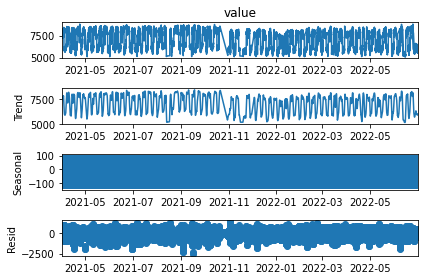

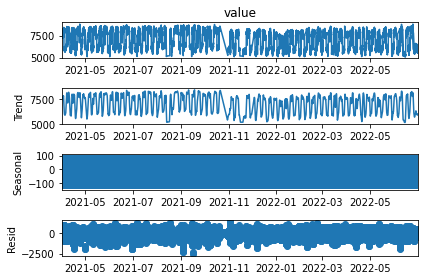

In [38]:
#decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# additive model: trend + cycle + seasonality + irregular factor

result1 = seasonal_decompose(ts['value'], model='Additive',extrapolate_trend='freq', period=10944) #1시간 단위    # 총 갯수: 43776 # 456일
# result1 = seasonal_decompose(ts['value'], model='Additive',extrapolate_trend='freq', period=21888) #30분 단위    # 43776
# result1 = seasonal_decompose(ts['value'], model='Additive',extrapolate_trend='freq', period=96) #하루 단위    # 총 갯수: 43776 # 456일
result1.plot()


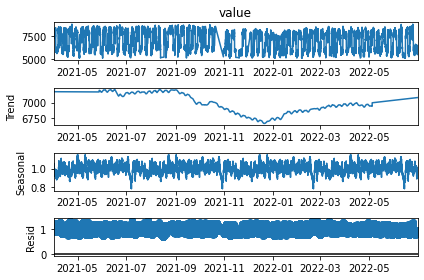

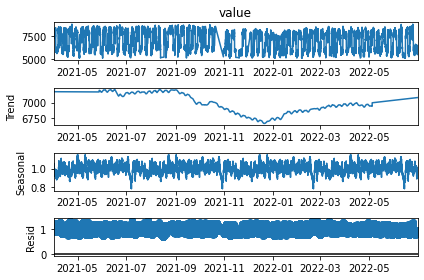

In [24]:
result2 = seasonal_decompose(ts['value'], model='multiplicative',extrapolate_trend='freq', period=10944)     # 1시간 단위
result2.plot()


In [31]:
#변동 계수
result1.resid.std()/result1.resid.mean()

-55.42821593041376

In [32]:
#변동계수
result2.resid.std()/result2.resid.mean()

0.13493194322688642

정상성 확인


acf(자기상관성)

In [9]:

def plot_acf_pacf(ts, figsize=(10,8)):  #,lags=0
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    fig,ax = plt.subplots(nrows=3, figsize=figsize)
    
    # Plot ts
    ts.plot(ax=ax[0])
    
    # Plot acf, pavf
    plot_acf(ts, ax=ax[1]) #, lags=lags
    plot_pacf(ts, ax=ax[2])  #, lags=lags

    return fig,ax

/home/ykkim/anaconda3/envs/pycaret/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


(<Figure size 720x576 with 3 Axes>,
 array([<AxesSubplot:xlabel='date'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

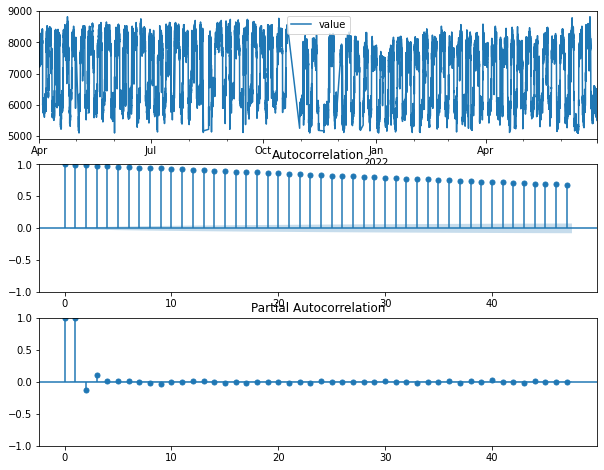

In [16]:

plot_acf_pacf(ts,figsize=(10,8))

/home/ykkim/anaconda3/envs/pycaret/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


(<Figure size 720x576 with 3 Axes>,
 array([<AxesSubplot:xlabel='date'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

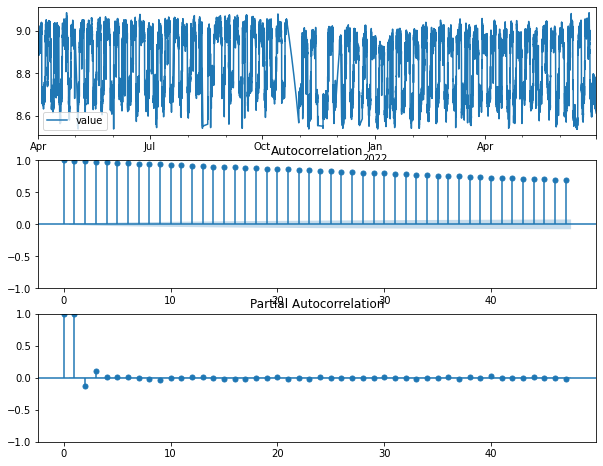

In [11]:

plot_acf_pacf(np.log(ts),figsize=(10,8))

1. 불안정시계열(비정상성) : Augmented Dickey-Fuller Test(ADF Test)   
H0: 시계열데이터가 안정적이지 않음     
H1 : 시계열데이터가 안정적임        
--> 계절성 있는 시계열 데이터에서 검정을 잘 해내지 못함

In [42]:
from statsmodels.tsa.stattools import adfuller
import math

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller메소드를 호출
    dftest = list(adfuller(timeseries, autolag='AIC'))
    dftest[0]=round(dftest[0],7)
    dftest[1]=round(dftest[1],7)
    dftest[2]=round(dftest[2],7)
    
    # adfuller메소드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test : ')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
    	dfoutput[f'Critical Value {key}'] = value
       
    
    print(dfoutput,list(dftest))
    



In [43]:
augmented_dickey_fuller_test(data['직전 15분 사용전력']) 


Results of Dickey-Fuller Test : 
Test Statistic                   -10.589763
p-value                            0.000000
#Lags Used                        48.000000
Number of Observations Used    42717.000000
Critical Value 1%                 -3.430503
Critical Value 5%                 -2.861608
Critical Value 10%                -2.566806
dtype: float64 [-10.5897631, 0.0, 48, 42717, {'1%': -3.430503093452298, '5%': -2.861607663907564, '10%': -2.566806015304407}, 539213.3640857383]


2. KPSS test  (계절성을 가지는 비정상 시계열 데이터 (non-stationary time series with seasonality))     
H0: 정상 시계열이다     
H1: 정상 시계열이 아니다  (채택)  


In [12]:
from statsmodels.tsa.stattools import kpss
import pandas as pd

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


In [15]:
kpss_test(ts)

Results of KPSS Test:
Test Statistic             0.843245
p-value                    0.010000
Lags Used                120.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


/home/ykkim/anaconda3/envs/pycaret/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [ ]:
###################################################################

In [81]:
#이상치 제거
# 5100 이하값들은 이전 값들로 대체
import numpy as np
data.loc[(data['직전 15분 사용전력'] <= 5100),'직전 15분 사용전력']= np.nan
data.isna().sum()
data=data.fillna(method='ffill')
data.isna().sum()
print(data['직전 15분 사용전력'].min(),data['직전 15분 사용전력'].max(),data['직전 15분 사용전력'].median())

5107.2 8820.0 7392.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


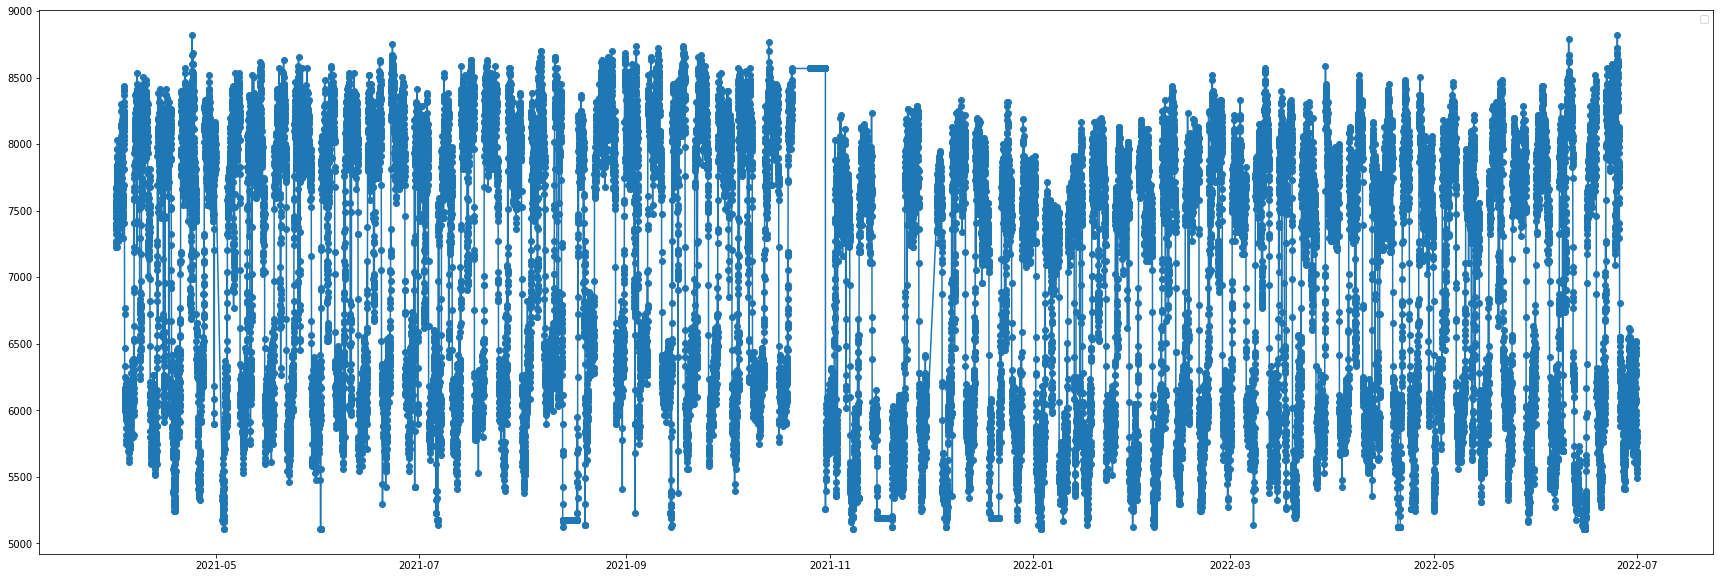

In [79]:
#plot
plt.figure(figsize=(30,10))
kws = dict(marker='o')
plt.plot(data['기준시각'],data['직전 15분 사용전력'], **kws)   
plt.legend()
plt.show()

In [5]:
#train_test split (Time Series)
def train_test_split(data,Time_name,train_cut_date,val_cut_date,end_time,want_val): # (data : dataframe , Time_name : 'dataframe 내 Time 변수명',want_val : validation set을 원할 경우'Y')

    data[Time_name]=pd.to_datetime(data[Time_name])
    df_train = data[data[Time_name] < train_cut_date ]
    df_test = data[(data[Time_name] >= val_cut_date) & (data[Time_name] <= end_time )] 
    print('train_df=',min(df_train[Time_name]),'~',max(df_train[Time_name]),',',len(df_train))
    print('test_df=',min(df_test[Time_name]),'~',max(df_test[Time_name]),',',len(df_test))

    if want_val=="Y":
        df_val= data[(data[Time_name] >= train_cut_date ) & (data[Time_name] < val_cut_date )]
        print('val_df=',min(df_val[Time_name]),'~',max(df_val[Time_name]),',',len(df_val))
        return (df_train,df_val,df_test) 

    return (df_train,df_test)  

In [6]:
#train_test split
df_train,df_test=train_test_split(data,Time_name='기준시각',train_cut_date='2022-06-30',val_cut_date='2022-06-30',end_time='2022-06-30 23:45:00',want_val='N')

train_df= 2021-04-01 00:00:00 ~ 2022-06-29 23:45:00 , 42670
test_df= 2022-06-30 00:00:00 ~ 2022-06-30 23:45:00 , 96


In [7]:
dti = pd.date_range("2021-04-01", periods=43680, freq="15min")  #43776 : 6/30까지
ds_freq=pd.DataFrame(dti)
ds_freq.columns=['기준시각']
ts_data=pd.merge(ds_freq,data,on='기준시각',how='left')
print(ts_data.isna().sum(),len(ts_data),len(data))

기준시각              0
직전 15분 사용전력    1010
dtype: int64 43680 42766


In [8]:
#test set
dti_t = pd.date_range("2022-06-30", periods=96, freq="15min")  #43776 : 6/30까지
ds_freq_t=pd.DataFrame(dti_t)
ds_freq_t.columns=['기준시각']
ts_data_t=pd.merge(ds_freq_t,data,on='기준시각',how='left')
print(ts_data_t.isna().sum(),len(ts_data_t),len(data))

기준시각           0
직전 15분 사용전력    0
dtype: int64 96 42766


In [9]:
ts_dd=pd.Series(ts_data['직전 15분 사용전력'])
ts_dd.index=ts_data['기준시각']
ts_dd

ts_dd_t=pd.Series(ts_data_t['직전 15분 사용전력'])
ts_dd_t.index=ts_data_t['기준시각']
ts_dd_t


기준시각
2022-06-30 00:00:00    5846.4
2022-06-30 00:15:00    5812.8
2022-06-30 00:30:00    5745.6
2022-06-30 00:45:00    5712.0
2022-06-30 01:00:00    5745.6
                        ...  
2022-06-30 22:45:00    5628.0
2022-06-30 23:00:00    5560.8
2022-06-30 23:15:00    5493.6
2022-06-30 23:30:00    5527.2
2022-06-30 23:45:00    5670.0
Name: 직전 15분 사용전력, Length: 96, dtype: float64

In [10]:
#missing data imputing(train)
ts_dd=ts_dd.fillna(method='ffill')

In [11]:
s = setup(ts_dd,fh = 4*2, fold = 5, session_id = 123)  #,fh=3,fold = 5

,Description,Value
0,session_id,123
1,Target,직전 15분 사용전력
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Data shape,"(43680, 1)"
5,Train data shape,"(43672, 1)"
6,Test data shape,"(8, 1)"
7,Fold Generator,ExpandingWindowSplitter
8,Fold Number,5
9,Enforce Prediction Interval,False


In [12]:
#This function trains and evaluates the performance
# of all the estimators available in the model library
#  using cross-validation. 
# The output of this function is a scoring grid with average cross-validated scores. Metrics evaluated during CV can be accessed using the get_metrics function. Custom metrics can be added or removed using add_metric and remove_metric function.
best = compare_models()

,Model,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2,TT (Sec)
croston,Croston,133.0697,149.1216,0.0226,0.0224,0.8454,0.5771,-2.4351,0.1100
exp_smooth,Exponential Smoothing,143.6166,159.5131,0.0243,0.0244,0.9125,0.6173,-3.1065,5.4540
ets,ETS,143.7833,159.6758,0.0243,0.0244,0.9135,0.6179,-3.1252,1.7400
theta,Theta Forecaster,143.5763,159.4321,0.0243,0.0244,0.9122,0.6170,-3.1053,3.2320
naive,Naive Forecaster,144.4800,160.7025,0.0244,0.0245,0.9179,0.6219,-3.1912,0.6420
arima,ARIMA,163.1357,183.4368,0.0276,0.0275,1.0365,0.7099,-4.1480,2.1340
snaive,Seasonal Naive Forecaster,166.3200,183.1459,0.0281,0.0281,1.0567,0.7088,-4.0881,0.0220
grand_means,Grand Means Forecaster,1077.8672,1080.8984,0.1817,0.1663,6.8480,4.1829,-215.9208,0.0180


In [13]:
best


Croston()

In [ ]:
# #hyperparametertunning
# tuned_models_list = [] #튜닝한 모델들을 리스트로 저장
# for i in best: 
#   tuned_model=tune_model(i,search_library = 'tune-sklearn', search_algorithm = 'hyperopt')
#   # tuned_model = tune_model(i, fold=30, optimize = 'MAPE', choose_better = True)
#   print(type(tuned_model))
#   tuned_models_list.append(tuned_model) # 모델들을 mape기준으로 튜닝합니다.

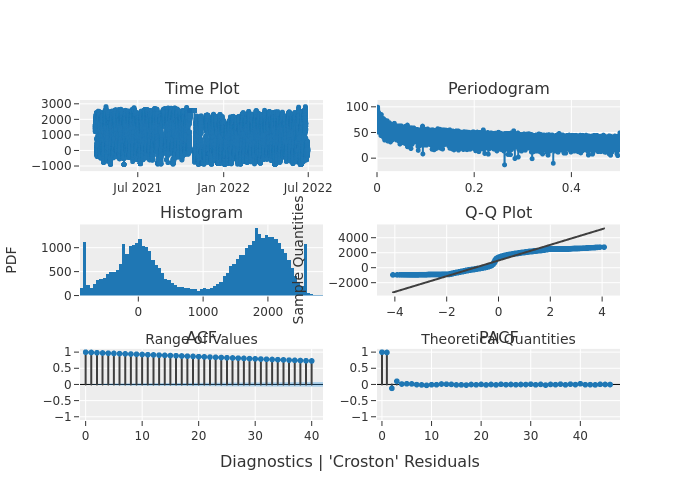

In [15]:
plot_model(best, plot = 'diagnostics')

In [16]:
untunedmodel=create_model(best)

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2022-06-29 11:45,44.1000,57.6177,0.0073,0.0073,0.2802,0.2229,-0.0355
1,2022-06-29 13:45,299.2926,318.7025,0.0522,0.0507,1.9016,1.2333,-7.4677
2,2022-06-29 15:45,69.8891,77.0201,0.0120,0.0119,0.4440,0.2981,-0.2195
3,2022-06-29 17:45,182.1016,206.6073,0.0299,0.0304,1.1570,0.7996,-3.4812
4,2022-06-29 19:45,69.9650,85.6602,0.0115,0.0116,0.4445,0.3315,-0.9714
Mean,NaT,133.0697,149.1216,0.0226,0.0224,0.8454,0.5771,-2.4351
SD,NaT,95.8371,99.6607,0.0167,0.0163,0.6089,0.3857,2.8011


,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2022-06-29 11:45,44.7884,56.7288,0.0074,0.0074,0.2845,0.2195,-0.0038
1,2022-06-29 13:45,292.8448,312.6552,0.0511,0.0497,1.8606,1.2099,-7.1494
2,2022-06-29 15:45,58.9280,69.7621,0.0100,0.0100,0.3744,0.2700,-0.0005
3,2022-06-29 17:45,199.0440,221.6847,0.0327,0.0333,1.2646,0.8579,-4.1592
4,2022-06-29 19:45,65.2252,79.2938,0.0108,0.0108,0.4144,0.3069,-0.6893
Mean,NaT,132.1661,148.0249,0.0224,0.0223,0.8397,0.5728,-2.4004
SD,NaT,97.7446,101.6985,0.0170,0.0166,0.6210,0.3936,2.8312


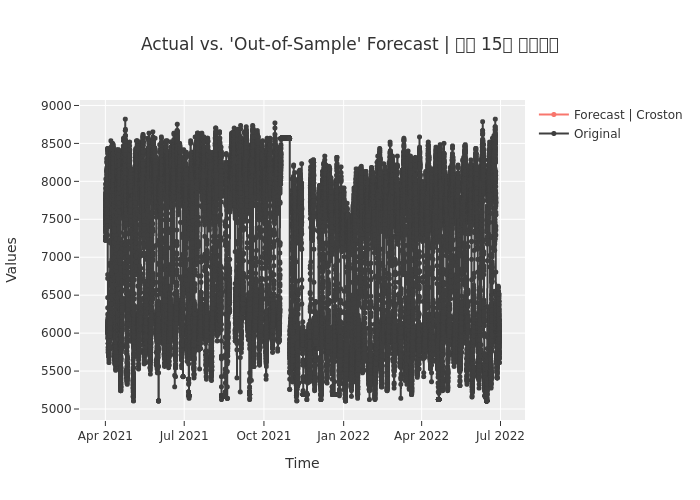

In [18]:
#### Tune the model (Default = Random Grid Search)
tuned_model_random = tune_model(untunedmodel)
plot_model(tuned_model_random)

In [19]:
#prediction
# finalize model
final_best = finalize_model(tuned_model_random)


/home/ykkim/anaconda3/envs/pycaret/lib/python3.9/site-packages/pycaret/utils/time_series/forecasting/model_selection.py:118: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lower = pd.Series([])
/home/ykkim/anaconda3/envs/pycaret/lib/python3.9/site-packages/pycaret/utils/time_series/forecasting/model_selection.py:119: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  upper = pd.Series([])
/home/ykkim/anaconda3/envs/pycaret/lib/python3.9/site-packages/pycaret/utils/time_series/forecasting/model_selection.py:118: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lower = pd.Series([])
/home/ykkim/anaconda3/envs/pycaret/lib/python3.9/site-packages/pycaret

In [27]:
predictions_future=predict_model(final_best) #,data=ts_dd_t
pred_df=pd.DataFrame(predictions_future)
# pred_df['ds']=pred_df.index
# pred_df=pred_df.reset_index(drop=True)
# concat_df_i = pd.date_range("2022-06-30", periods=4*24, freq="15min") 
# # pred_df.set_index(concat_df_i, inplace=True)
# pred_df['직전15분사용전력']=ts_data_t['직전 15분 사용전력'][0:4*24]

In [28]:
pred_df

,y_pred
2022-06-30 00:00,5888.5078
2022-06-30 00:15,5888.5078
2022-06-30 00:30,5888.5078
2022-06-30 00:45,5888.5078
2022-06-30 01:00,5888.5078
2022-06-30 01:15,5888.5078
2022-06-30 01:30,5888.5078
2022-06-30 01:45,5888.5078


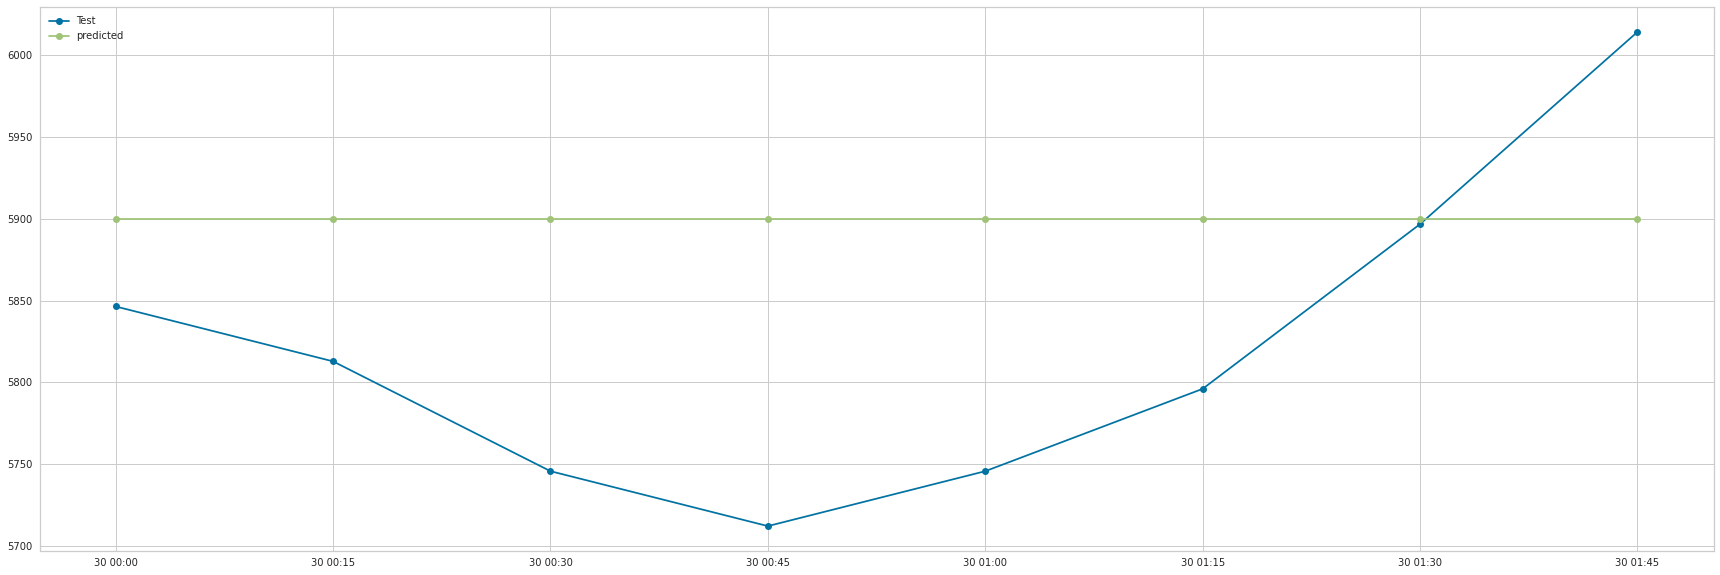

In [29]:
import matplotlib.pyplot as plt
# predict, real 비교 plot
def predict_graph(test,prediction) : 

    #plot
    plt.figure(figsize=(30,10))
    kws = dict(marker='o')
    plt.plot(test, label='Test', **kws)   
    plt.plot(prediction,label='predicted', **kws)
    plt.legend()
    return plt.show()

predict_graph(pred_df['직전15분사용전력'],pred_df['y_pred'])

In [30]:
#save the model
save_model(final_best, '/home/ykkim/pipeline_from_AutoML/pycaret/Moorim_2hour_predict')


Transformation Pipeline and Model Successfully Saved


(Croston(),
 '/home/ykkim/pipeline_from_AutoML/pycaret/Moorim_2hour_predict.pkl')

In [31]:
loaded_model = load_model('/home/ykkim/pipeline_from_AutoML/pycaret/Moorim_3hour_predict')
print(loaded_model)

Transformation Pipeline and Model Successfully Loaded
ExponentialSmoothing(seasonal='mul', sp=4, trend='add')


In [32]:
loaded_model.predict()

2022-06-30 00:00    5933.659531
2022-06-30 00:15    5926.247400
2022-06-30 00:30    5935.219384
2022-06-30 00:45    5921.809389
2022-06-30 01:00    5933.493907
2022-06-30 01:15    5926.081982
2022-06-30 01:30    5935.053713
2022-06-30 01:45    5921.644092
2022-06-30 02:00    5933.328282
2022-06-30 02:15    5925.916563
2022-06-30 02:30    5934.888043
2022-06-30 02:45    5921.478794
Freq: 15T, dtype: float64

https://pycaret.gitbook.io/docs/learn-pycaret/official-blog/time-series-101-for-beginners
# regression


In [1]:
# from Sequential.FeatureSelector import SequentialFeatureSelector 
from pycaret.regression import *

ImportError: cannot import name 'SequentialFeatureSelector' from 'sklearn.feature_selection' (/home/ykkim/anaconda3/envs/pycaret/lib/python3.9/site-packages/sklearn/feature_selection/__init__.py)

In [ ]:
import pandas as pd
data=pd.read_excel('/home/ykkim/Train_data/무림페이퍼_15분사용전력_210401-220630.xlsx')  
data=data.drop(['등록시각'],axis=1)

data['기준시각']=pd.to_datetime(data['기준시각'])
data.info()
len(data)

In [ ]:
# initialize setup**
s = setup(data = ts_dd, test_data = test, target = 'Passengers', fold_strategy = 'timeseries', numeric_features = ['Year', 'Series'], fold = 3, transform_target = True, session_id = 123)

In [2]:
import pycaret   #pip install --pre pycaret
import sklearn
print(pycaret.__version__)
print(sklearn.__version__)

3.0.0
0.23.2
